Feature Engineering

In [ ]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import statsmodels.api as sm

## Distance to City Feature

In [ ]:
from geopy.distance import geodesic

# Load the excel file
df = pd.read_excel('listings.xlsx')

# Define the coordinates for the city center (Sydney Opera House)
city_center_coords = (-33.8568, 151.2153)

# Calculate the distance from each listing to the city center
df['distance_to_city_center'] = df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), city_center_coords).kilometers, axis=1
)

# Display the first few rows to verify the new column
print(df[['latitude', 'longitude', 'distance_to_city_center']].head())

    latitude   longitude  distance_to_city_center
0 -33.823050  151.197690                 4.082983
1 -33.926394  151.255278                 8.559447
2 -33.845370  151.201254                 1.815759
3 -33.793030  151.284740                 9.557995
4 -30.886500  153.042701               371.559276


## Interaction terms, High-rated features

In [ ]:
# Create interaction terms and additional features
df['bedrooms_bathrooms'] = df['bedrooms'] * df['bathrooms']
df['bedrooms_accommodates'] = df['bedrooms'] * df['accommodates']
df['bathrooms_accommodates'] = df['bathrooms'] * df['accommodates']
df['is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})

# Convert review_scores_rating to numeric, replacing 'Not Reviewed' with NaN
df['review_scores_rating'] = pd.to_numeric(df['review_scores_rating'], errors='coerce')

# Create a feature for high-rated listings
df['is_high_rated'] = (df['review_scores_rating'] >= 4.5).astype(int)

# Step 6: Display summary statistics for the new features
print("Summary statistics for new features:")
print(df[['bedrooms_bathrooms', 'bedrooms_accommodates', 'bathrooms_accommodates', 'is_superhost', 'is_high_rated']].describe())

Summary statistics for new features:
       bedrooms_bathrooms  bedrooms_accommodates  bathrooms_accommodates  \
count        37636.000000           37636.000000            37636.000000   
mean             3.758449              11.426799                7.879371   
std              4.979316              14.877802                9.826010   
min              0.000000               0.000000                0.000000   
25%              1.000000               2.000000                2.000000   
50%              2.000000               8.000000                4.000000   
75%              4.500000              18.000000               10.000000   
max            169.000000             560.000000              208.000000   

       is_superhost  is_high_rated  
count           0.0   37636.000000  
mean            NaN       0.636731  
std             NaN       0.480948  
min             NaN       0.000000  
25%             NaN       0.000000  
50%             NaN       1.000000  
75%             NaN

## Combined availability - with more weightage on short term to reflect flexibility, and "is peak season" to show if it is summer

In [ ]:
# Calculate the combined availability percentage
df['combined_availability'] = (
    (df['availability_30'] / 30 * 0.4) +
    (df['availability_60'] / 60 * 0.3) +
    (df['availability_90'] / 90 * 0.2) +
    (df['availability_365'] / 365 * 0.1)
)

# Step 2: Determine if the listing is in peak season (summer)

# Assuming today is October 8, 2024
current_date = pd.Timestamp('2024-10-08')

# Calculate days until summer (December 1, 2024)
days_until_summer = (pd.Timestamp('2024-12-01') - current_date).days

# Calculate availability for summer months
df['is_peak_season (summer)'] = (
    (df['availability_60'] >= days_until_summer) |  # Available when summer starts
    (df['availability_90'] >= days_until_summer + 30) |  # Available in first month of summer
    (df['availability_365'] >= days_until_summer + 90)  # Available for full summer
).astype(int)

# Display the first few rows of the updated feature
print(df[['combined_availability', 'is_peak_season (summer)']].head(10))

   combined_availability  is_peak_season (summer)
0               0.435715                        0
1               0.217694                        1
2               0.000000                        0
3               0.000000                        0
4               0.511895                        1
5               0.183333                        1
6               0.886826                        1
7               0.020830                        0
8               0.906826                        1
9               0.729216                        1


## Log transformation for price - reduce skewness

In [ ]:
# Import numpy for the log transformation
import numpy as np

# Apply log transformation to the 'price' column and create a new column 'log_price'
df['log_price'] = np.log1p(df['price'])

# Verify the transformation by displaying the first few rows of the updated dataframe
print(df[['price', 'log_price']].head())

   price  log_price
0  151.0   5.023881
1  224.0   5.416100
2  332.0   5.808142
3  189.0   5.247024
4  445.0   6.100319


C:\Users\ALIENWARE\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Hiearchy type for property type

In [ ]:
# Define a simplified hierarchy for 'property_type'
property_type_hierarchy = {
    'Shared': 1,
    'Private': 2,
    'Entire': 3,
    'Room': 2,
}

# Function to map property types to ordinal values
def map_property_type(prop_type):
    for key, value in property_type_hierarchy.items():
        if key in prop_type:
            return value
    return 2  # Default value for unknown types

# Convert 'property_type' to ordinal
df['property_type_ordinal'] = df['property_type'].apply(map_property_type)

# Display the first few rows of the new ordinal column
print(df[['property_type', 'property_type_ordinal']].head(10))

                 property_type  property_type_ordinal
0           Entire rental unit                      3
1  Private room in rental unit                      2
2           Entire rental unit                      3
3           Entire rental unit                      3
4                  Entire home                      3
5                  Entire home                      3
6                  Entire home                      3
7           Entire rental unit                      3
8            Entire guesthouse                      3
9    Entire serviced apartment                      3


## Hiearchy for Room type

In [ ]:
# Check unique values in 'room_type'
print("Unique room types:", df['room_type'].unique())

# Define a hierarchy for 'room_type'
room_type_hierarchy = {
    'Shared room': 1,
    'Private room': 2,
    'Entire home/apt': 3,
    'Hotel room': 4
}

# Convert 'room_type' to ordinal
df['room_type_ordinal'] = df['room_type'].map(room_type_hierarchy)

# Display the first few rows of the new ordinal column
print("\
First 10 rows of room types and their ordinal values:")
print(df[['room_type', 'room_type_ordinal']].head(10))

Unique room types: ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
First 10 rows of room types and their ordinal values:
         room_type  room_type_ordinal
0  Entire home/apt                  3
1     Private room                  2
2  Entire home/apt                  3
3  Entire home/apt                  3
4  Entire home/apt                  3
5  Entire home/apt                  3
6  Entire home/apt                  3
7  Entire home/apt                  3
8  Entire home/apt                  3
9  Entire home/apt                  3


## Listing age (in days) & days since last review

In [ ]:
from datetime import datetime

print("First 10 rows of host_since:")
print(df['host_since'].head(10))

new_current_date = datetime(2024, 10, 8)

# Define function to parse dates with multiple possible formats
def parse_date(date_str):
    date_formats = ['%Y-%m-%dT%H:%M:%S.%f', '%d-%m-%Y', '%Y-%m-%d']
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.NaT  # Return NaT (Not a Time) if no format matches

# Apply the parsing function to 'host_since'
df['host_since_parsed'] = df['host_since'].apply(parse_date)

# Recalculate 'listing_age' using the parsed 'host_since' dates
df['listing_age (in days)'] = (new_current_date - df['host_since_parsed']).dt.days

# Recalculate 'days_since_last_review' using the new current date
df['days_since_last_review'] = (new_current_date - pd.to_datetime(df['last_review'], errors='coerce')).dt.days

# Fill missing values in 'days_since_last_review' with 'Not Reviewed'
df['days_since_last_review'] = df['days_since_last_review'].fillna('Not Reviewed')

# Display the first few rows to verify the change
print("First 10 rows of listing_age (in days) and days_since_last_review:")
print(df[['listing_age (in days)', 'days_since_last_review']].head(10))

First 10 rows of host_since:
0   2017-04-10
1   2014-11-17
2   2019-07-24
3   2013-10-04
4   2020-08-18
5   2016-06-19
6   2016-07-14
7   2019-01-16
8   2011-11-21
9   2016-01-20
Name: host_since, dtype: datetime64[ns]
First 10 rows of listing_age (in days) and days_since_last_review:
   listing_age (in days) days_since_last_review
0                 2738.0                  317.0
1                 3613.0                  502.0
2                 1903.0                  635.0
3                 4022.0                 3172.0
4                 1512.0           Not Reviewed
5                 3033.0           Not Reviewed
6                 3008.0                 1262.0
7                 2092.0                  484.0
8                 4705.0           Not Reviewed
9                 3184.0                  495.0


Host since 10/08/2024

In [ ]:
data = pd.read_excel('listings (3).xlsx')

In [ ]:
data['host_since'] = pd.to_datetime(data['host_since'], errors='coerce')
reference_date = pd.to_datetime('2024-10-22')
data['host_since_months'] = (reference_date - data['host_since']).dt.days / 30
data[['host_since', 'host_since_months']].head()

,host_since,host_since_months
0,2017-04-10,91.733333
1,2014-11-17,120.900000
2,2019-07-24,63.900000
3,2013-10-04,134.533333
4,2020-08-18,50.866667


## New Excel file with the new features & transformation for Training

# Transformation to numerical and fill missing values to 0

In [ ]:
def transform_dataframe(data):
    # Map 'instant_bookable' values to 0 and 1
    data['instant_bookable'] = data['instant_bookable'].map({'f': 0, 't': 1})

    # Fill missing values in 'review_scores_rating' and 'listing_age (in days)' with 0
    data['review_scores_rating'] = data['review_scores_rating'].fillna(0)
    data['listing_age (in days)'] = data['listing_age (in days)'].fillna(0)

    # Replace 'Not Reviewed' in 'days_since_last_review' with 0 and convert to numeric
    data['days_since_last_review'] = data['days_since_last_review'].replace('Not Reviewed', 0)
    data['days_since_last_review'] = pd.to_numeric(data['days_since_last_review'], errors='coerce')

    # Fill missing values in 'instant_bookable' with 0
    data['instant_bookable'] = data['instant_bookable'].fillna(0)

    # Return the transformed dataframe
    return data

# Apply the transformation to 'data'
transformed_data = transform_dataframe(df)

# Display the first few rows to verify all transformations
print("First few rows after all transformations:")
print(transformed_data[['instant_bookable', 'review_scores_rating', 'listing_age (in days)', 'days_since_last_review']].head())

First few rows after all transformations:
   instant_bookable  review_scores_rating  listing_age (in days)  \
0                 0                  4.66                 2738.0   
1                 0                  5.00                 3613.0   
2                 0                  4.63                 1903.0   
3                 0                  5.00                 4022.0   
4                 1                  0.00                 1512.0   

   days_since_last_review  
0                   317.0  
1                   502.0  
2                   635.0  
3                  3172.0  
4                     0.0  


In [ ]:
#drop unecessary columns
#drop variables
data = data.drop(columns=['name','picture_url', 'host_url','host_about'])
#data = data.drop(columns=['accommodates','number_of_reviews','number_of_reviews_ltm','availability_30', 'availability_60', 'availability_90', 'availability_365'])

In [ ]:
data.columns

Index(['neighborhood_overview', 'host_id', 'host_name', 'host_since',
       'listing_age (in days)', 'days_since_last_review', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'property_type', 'property_type_ordinal', 'room_type',
       'room_type_ordinal', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       

# Data Processing

In [ ]:
#changing boolean format
data.replace({'t': 1, 'f': 0}, inplace=True)

In [ ]:
#fill boolean missing values with 0/False
bool_columns = data.columns[data.columns.isin(['host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable'])]
data[bool_columns] = data[bool_columns].fillna(0)

In [ ]:
data.columns
#new features --> 'distance_to_city_center (in km)', 'has_reviews', 'log_price', 'price_category', 'review_frequency','bedrooms_bathrooms',
#'bedrooms_accommodates', 'bathrooms_accommodates', 'price_per_person', 'is_high_rated', 'combined_availability','is_peak_season (summer)'

Index(['neighborhood_overview', 'host_id', 'host_name', 'host_since',
       'listing_age (in days)', 'days_since_last_review', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'property_type', 'property_type_ordinal', 'room_type',
       'room_type_ordinal', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       

In [ ]:
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                  'review_scores_value']
data[review_columns] = data[review_columns].replace('not reviewed', 0).fillna(0)

In [ ]:
columns_with_not_reviewed = data.columns[data.isin(['Not Reviewed']).any()]
data[columns_with_not_reviewed] = data[columns_with_not_reviewed].replace('Not Reviewed', np.nan)

In [ ]:
#check distance_to_city_center (in km)
data['distance_to_city_center (in km)'].describe()

# Define the distance categories
#close = 0-10
#medium = 11-300
#far = 300+

count    37636.000000
mean       164.776772
std        242.030141
min          0.361371
25%          5.983863
50%         12.148232
75%        317.112079
max        669.236694
Name: distance_to_city_center (in km), dtype: float64

In [ ]:
#removing outliers
#remove values over $2500
data = data[data['price'] <= 2500]

# Removing Outliers

In [ ]:
#removing outliers
#new data --> data_cleaned
def remove_outliers_grouped(df, target_column, groupby_column):
    # Calculate Q1, Q3, and IQR for each group
    Q1 = df.groupby(groupby_column)[target_column].quantile(0.25)
    Q3 = df.groupby(groupby_column)[target_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply the filtering logic based on the computed IQR bounds
    def is_non_outlier(row):
        return lower_bound[row[groupby_column]] <= row[target_column] <= upper_bound[row[groupby_column]]

    # Filter out rows where outliers are detected
    non_outliers = df.apply(is_non_outlier, axis=1)
    return df[non_outliers]

# Drop rows with NaN values in 'log_price' and 'room_type_ordinal' columns
data_clean = data.dropna(subset=['log_price', 'room_type_ordinal'])

# Remove outliers based on 'log_price' for each 'room_type_ordinal' group
data_cleaned = remove_outliers_grouped(data_clean, 'log_price', 'room_type_ordinal')

# Verify the shape of the data after outlier removal
print(f"Original data shape: {data_clean.shape}")
print(f"Data shape after outlier removal: {data_cleaned.shape}")

Original data shape: (37310, 61)
Data shape after outlier removal: (36986, 61)


# EDA

## 1 - GeoPlot

In [ ]:
unique_values_property_type_ordinal = data['property_type'].unique()

# Display the unique values
print(unique_values_property_type_ordinal)

['Entire rental unit' 'Private room in rental unit' 'Entire home'
 'Entire guesthouse' 'Entire serviced apartment' 'Farm stay'
 'Private room in home' 'Entire guest suite' 'Entire cabin'
 'Entire cottage' 'Private room in bed and breakfast' 'Hut'
 'Entire townhouse' 'Room in aparthotel' 'Private room in tent'
 'Private room in townhouse' 'Camper/RV' 'Entire villa'
 'Private room in villa' 'Private room in condo' 'Shared room in home'
 'Entire loft' 'Entire vacation home' 'Private room in farm stay'
 'Room in boutique hotel' 'Tent' 'Entire condo' 'Entire bungalow'
 'Private room in ranch' 'Room in hotel' 'Shared room in rental unit'
 'Private room in guest suite' 'Room in serviced apartment' 'Train'
 'Shared room' 'Entire place' 'Private room in bungalow' 'Private room'
 'Private room in guesthouse' 'Private room in tipi'
 'Shared room in condo' 'Holiday park' 'Barn' 'Private room in loft'
 'Private room in resort' 'Island' 'Dome' 'Tiny home' 'Houseboat'
 'Earthen home' 'Private room in

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

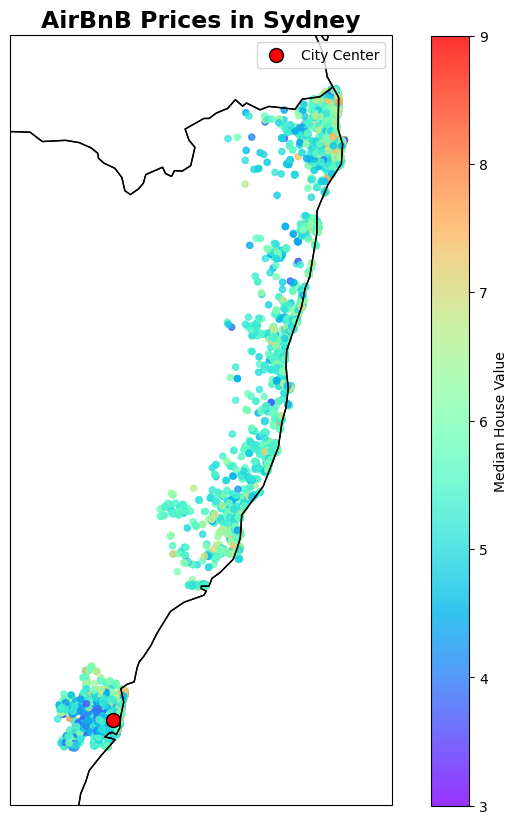

In [ ]:
longitude = data['longitude'].to_numpy()
latitude = data['latitude'].to_numpy()
median_price = data['log_price'].to_numpy()  # Assuming 'log_price' is the median property price column

city_center_lat, city_center_lon = -33.8568, 151.2153

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

vmin = 3   # Minimum value for the color bar (adjust based on your data)
vmax = 9  # Maximum value for the color bar (adjust based on your data)

sc = ax.scatter(longitude, latitude, s=20, c=median_price, cmap=plt.get_cmap('rainbow'), alpha=0.8, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ax.scatter(city_center_lon, city_center_lat, color='red', s=100, marker='o', edgecolor='black', transform=ccrs.PlateCarree(), label='City Center')

ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

buffer = 0.5
ax.set_extent([min(longitude) - buffer, max(longitude) + buffer, min(latitude) - buffer, max(latitude) + buffer], crs=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='Median House Value')
ax.set_title('AirBnB Prices in Sydney', fontsize=17, fontweight='bold')
ax.legend()
plt.show()

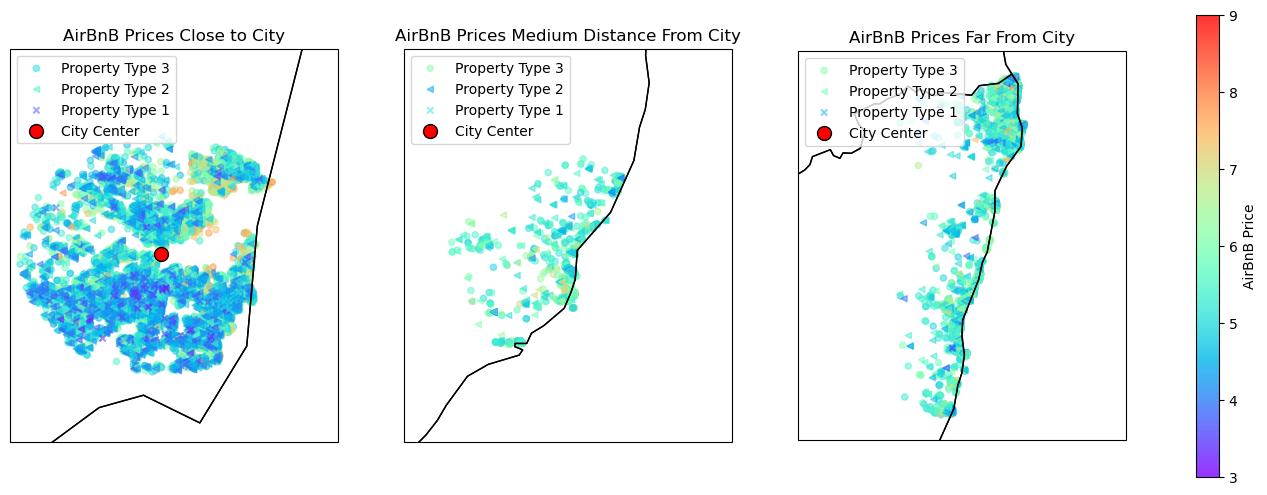

In [ ]:
# Assign different markers for each property_type_ordinal
marker_dict = {1: 'x', 2: '<', 3: 'o'}  # 'o' for type 1, '^' for type 2, 's' for type 3

# Divide the data based on distance to city center
close = data[data['distance_to_city_center (in km)'] <= 10]
medium = data[(data['distance_to_city_center (in km)'] > 10) & (data['distance_to_city_center (in km)'] <= 300)]
far = data[data['distance_to_city_center (in km)'] > 300]

# Set up the plotting space for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
datasets = [(close, 'Close to City'), (medium, 'Medium Distance From City'), (far, 'Far From City')]

vmin = 3  # Minimum value for color bar
vmax = 9  # Maximum value for color bar

city_center_lat, city_center_lon = -33.8568, 151.2153

for ax, (subset, title) in zip(axes, datasets):
    # Define the extent for each subset
    if title == 'Close to City':
        ax.set_extent([151.1, 151.35, -34.0, -33.7], crs=ccrs.PlateCarree())
    elif title == 'Medium Distance From City':
        lon_min, lon_max = subset['longitude'].min(), subset['longitude'].max()
        lat_min, lat_max = subset['latitude'].min(), subset['latitude'].max()
        ax.set_extent([lon_min + 0.75, lon_max + 0.75, lat_min + 0.75, lat_max + 0.75], crs=ccrs.PlateCarree())
    else:
        lon_min, lon_max = subset['longitude'].min(), subset['longitude'].max()
        lat_min, lat_max = subset['latitude'].min(), subset['latitude'].max()
        ax.set_extent([lon_min - 1, lon_max + 1, lat_min - 0.25, lat_max + 0.25], crs=ccrs.PlateCarree())

    # Plot each property type with a different marker
    for property_type in subset['property_type_ordinal'].unique():
        type_subset = subset[subset['property_type_ordinal'] == property_type]
        ax.scatter(type_subset['longitude'], type_subset['latitude'], s=20, c=type_subset['log_price'],
                   marker=marker_dict[property_type], cmap=plt.get_cmap('rainbow'), alpha=0.5, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), label=f'Property Type {property_type}')

    # Add city center marker
    ax.scatter(city_center_lon, city_center_lat, color='red', s=100, marker='o', edgecolor='black', transform=ccrs.PlateCarree(), label='City Center')

    # Add features (state borders and coastlines)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

    ax.set_title(f'AirBnB Prices {title}', fontsize=12)

    ax.legend(loc='upper left')

# Add a single colorbar for all plots
fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', label='AirBnB Price')

# Save the plot to a file
plt.savefig('AirBnBPricesPlotDistType.pdf')
plt.show()

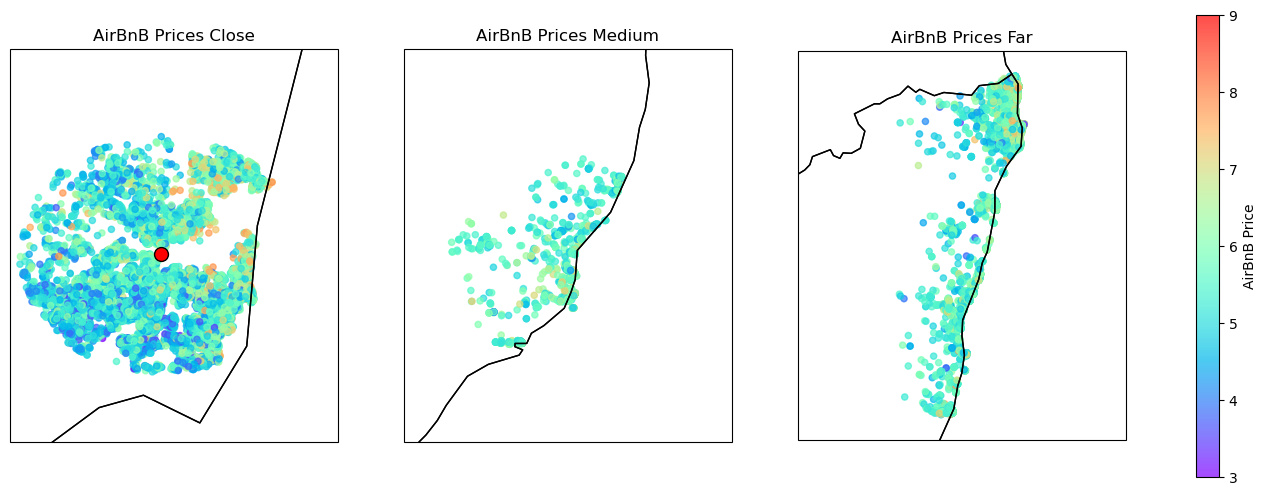

In [ ]:
close = data[data['distance_to_city_center (in km)'] <= 10]
medium = data[(data['distance_to_city_center (in km)'] > 10) & (data['distance_to_city_center (in km)'] <= 300)]
far = data[data['distance_to_city_center (in km)'] > 300]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
datasets = [(close, 'Close'), (medium, 'Medium'), (far, 'Far')]

vmin = 3  # Adjust based on your data
vmax = 9  # Adjust based on your data

city_center_lat, city_center_lon = -33.8568, 151.2153

for ax, (subset, title) in zip(axes, datasets):
    # Define the extent for each subset
    if title == 'Close':
        # Zoom in for the "Close" plot with slightly expanded boundaries to avoid cropping
        ax.set_extent([151.1, 151.35, -34.0, -33.7], crs=ccrs.PlateCarree())
    elif title == 'Medium':
        # Set the extent based on the min and max longitude and latitude for the medium subset
        lon_min, lon_max = subset['longitude'].min(), subset['longitude'].max()
        lat_min, lat_max = subset['latitude'].min(), subset['latitude'].max()
        ax.set_extent([lon_min + 0.75, lon_max + 0.75, lat_min + 0.75, lat_max + 0.75], crs=ccrs.PlateCarree())
    else:
        # Set the extent for the "Far" range
        lon_min, lon_max = subset['longitude'].min(), subset['longitude'].max()
        lat_min, lat_max = subset['latitude'].min(), subset['latitude'].max()
        ax.set_extent([lon_min - 1, lon_max + 1, lat_min - 0.25, lat_max + 0.25], crs=ccrs.PlateCarree())

    sc = ax.scatter(subset['longitude'], subset['latitude'], s=20, c=subset['log_price'], cmap=plt.get_cmap('rainbow'), alpha=0.7, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    ax.scatter(city_center_lon, city_center_lat, color='red', s=100, marker='o', edgecolor='black', transform=ccrs.PlateCarree(), label='City Center')

    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

    ax.set_title(f'AirBnB Prices {title}', fontsize=12)

fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', label='AirBnB Price')
plt.savefig('AirBnBPricesPlot.pdf')

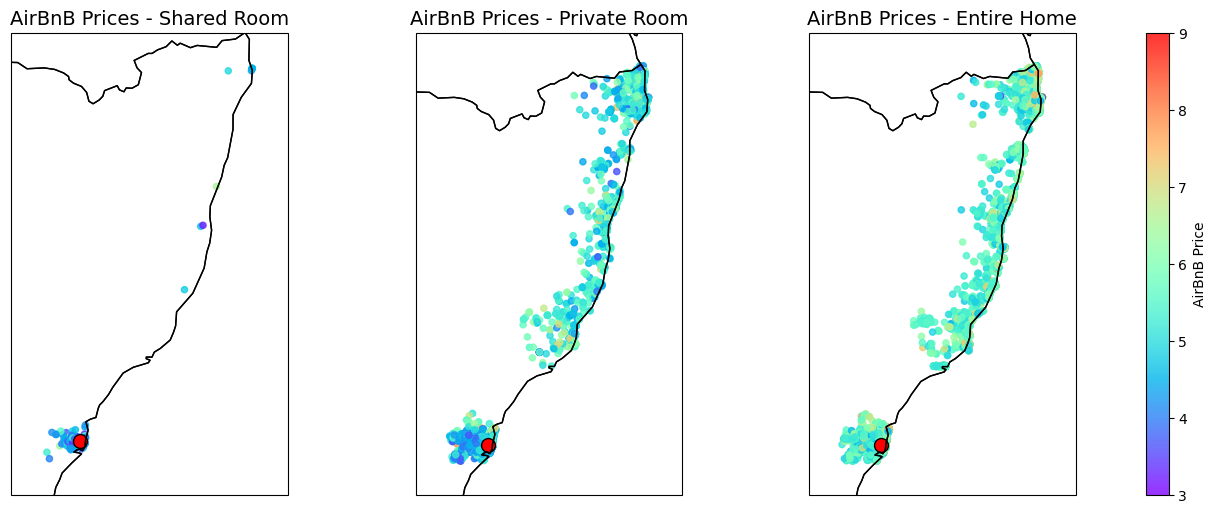

In [ ]:
property_type_1 = data[data['property_type_ordinal'] == 1]
property_type_2 = data[data['property_type_ordinal'] == 2]
property_type_3 = data[data['property_type_ordinal'] == 3]

# Create figure for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot for each property type
property_datasets = [(property_type_1, 'Shared Room'), (property_type_2, 'Private Room'), (property_type_3, 'Entire Home')]

vmin = 3   # Minimum value for the color bar
vmax = 9   # Maximum value for the color bar

# City center coordinates
city_center_lat, city_center_lon = -33.8568, 151.2153

# Loop through the property datasets
for ax, (subset, title) in zip(axes, property_datasets):
    longitude = subset['longitude'].to_numpy()
    latitude = subset['latitude'].to_numpy()
    median_price = subset['log_price'].to_numpy()

    # Scatter plot for each property type
    sc = ax.scatter(longitude, latitude, s=20, c=median_price, cmap=plt.get_cmap('rainbow'), alpha=0.8, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    # Add a red dot for the city center
    ax.scatter(city_center_lon, city_center_lat, color='red', s=100, marker='o', edgecolor='black', transform=ccrs.PlateCarree(), label='City Center')

    # Add features (state borders and coastlines)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

    # Set the extent with a buffer to avoid cropping
    buffer = 0.5
    ax.set_extent([min(longitude) - buffer, max(longitude) + buffer, min(latitude) - buffer, max(latitude) + buffer], crs=ccrs.PlateCarree())

    # Add title for each plot
    ax.set_title(f'AirBnB Prices - {title}', fontsize=14)

# Add a single colorbar for all plots
fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', label='AirBnB Price')

# Display the plots
plt.savefig('AirBnBPricesbyRoom.pdf')

## 2 - Correlation Heatmap

In [ ]:
# Load the dataset and create X_train
data = pd.read_excel('listings (3).xlsx')

# Remove the target variable (price) to create X_train
X_train = data.drop(['price'], axis=1)

# List numerical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns in the dataset:")
print(numerical_columns)

Numerical columns in the dataset:
['host_id', 'listing_age (in days)', 'host_is_superhost', 'host_total_listings_count', 'latitude', 'longitude', 'property_type_ordinal', 'room_type_ordinal', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'calculated_host_listings_count', 'distance_to_city_center (in km)', 'log_price', 'bedrooms_bathrooms', 'bedrooms_accommodates', 'bathrooms_accommodates', 'price_per_person', 'is_high_rated', 'combined_availability', 'is_peak_season (summer)']


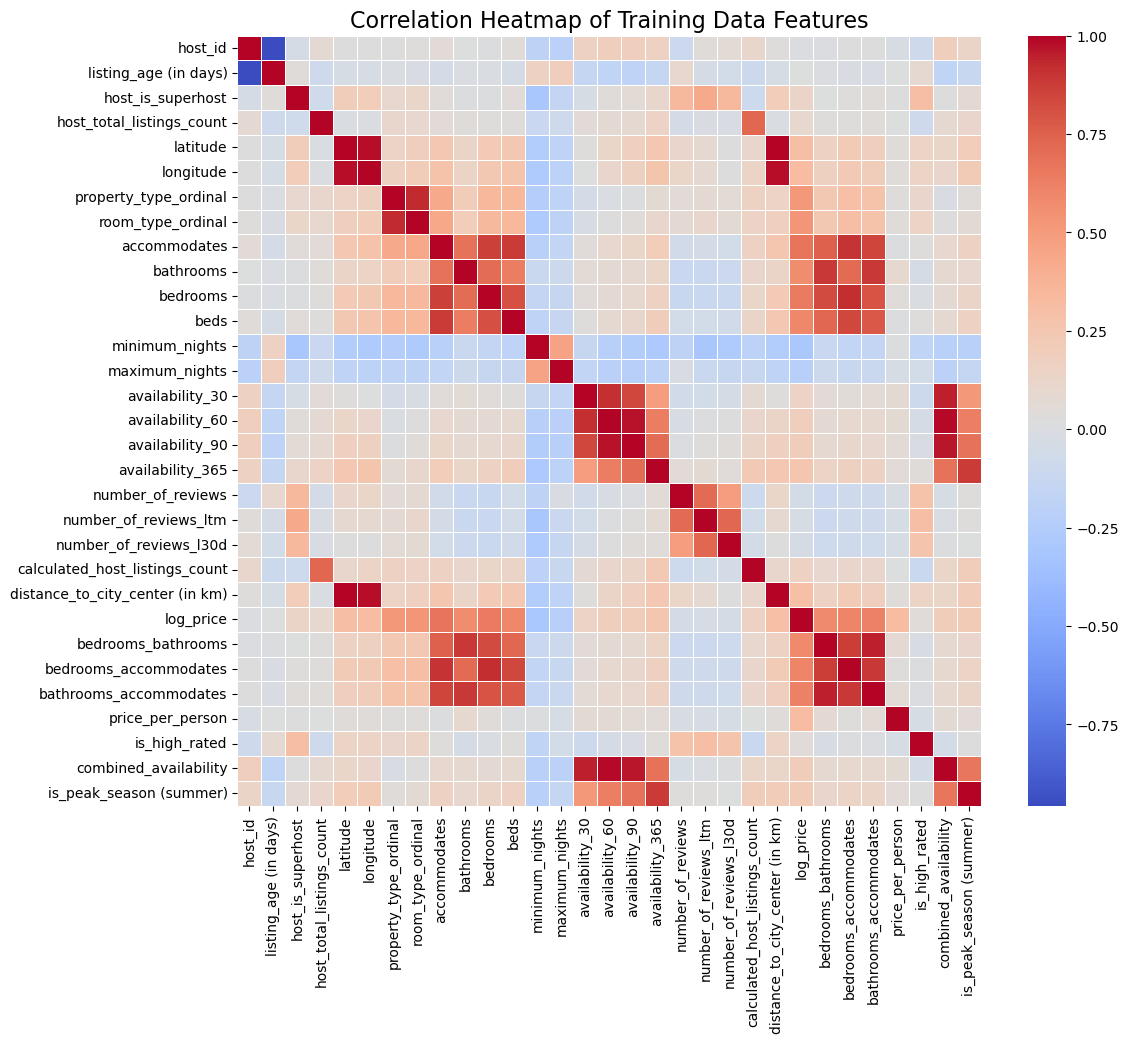

In [ ]:
# Selecting only the numerical columns from the training data
X_train_numerical = X_train[numerical_columns]

# Compute the correlation matrix for the numerical training data
correlation_matrix = X_train_numerical.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Training Data Features', fontsize=16)
plt.savefig('correlationnumerical.pdf')

C:\Users\ALIENWARE\AppData\Local\Temp\ipykernel_18380\2724213959.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_numerical.corr()


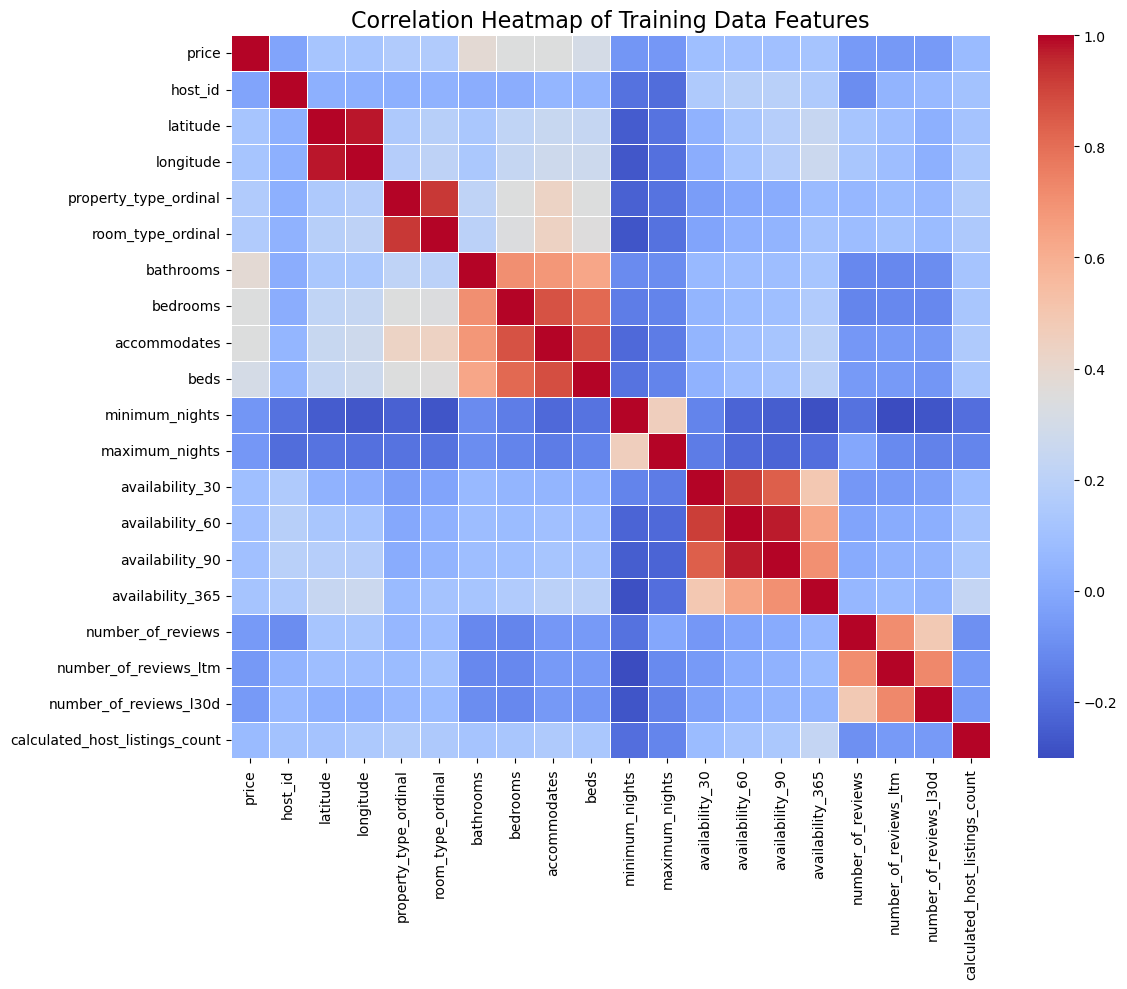

In [ ]:
#correlation - only with original data
numerical_columns = ['price','host_id',
 'latitude',
 'longitude',
 'property_type_ordinal',
 'room_type_ordinal',
 'bathrooms', 'bedrooms',
 'accommodates',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count']

# Selecting only the numerical columns from the training data
data_numerical = data[numerical_columns]

# Compute the correlation matrix for the numerical training data
correlation_matrix = data_numerical.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Training Data Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlationnumerical.png')

In [ ]:
#omit variables
#'accommodates','number_of_reviews','number_of_reviews_ltm','availability_30', 'availability_60', 'availability_90', 'availability_365'

## Regression Plot of Best Variables

In [ ]:
data['review_scores_rating'] = data['review_scores_rating'].replace('Not Reviewed', np.nan)
data['review_scores_rating'] = pd.to_numeric(data['review_scores_rating'], errors='coerce').astype('Float64')

In [ ]:
data['log_review_scores_rating'] = np.log(data['review_scores_rating'] + 1)
data['log_availability_365'] = np.log(data['availability_365'] + 1)

In [ ]:
data.dtypes

name                         object
neighborhood_overview        object
picture_url                  object
host_id                       int64
host_url                     object
                             ...   
is_high_rated                 int64
combined_availability       float64
is_peak_season (summer)       int64
log_review_scores_rating    Float64
log_availability_365        float64
Length: 66, dtype: object

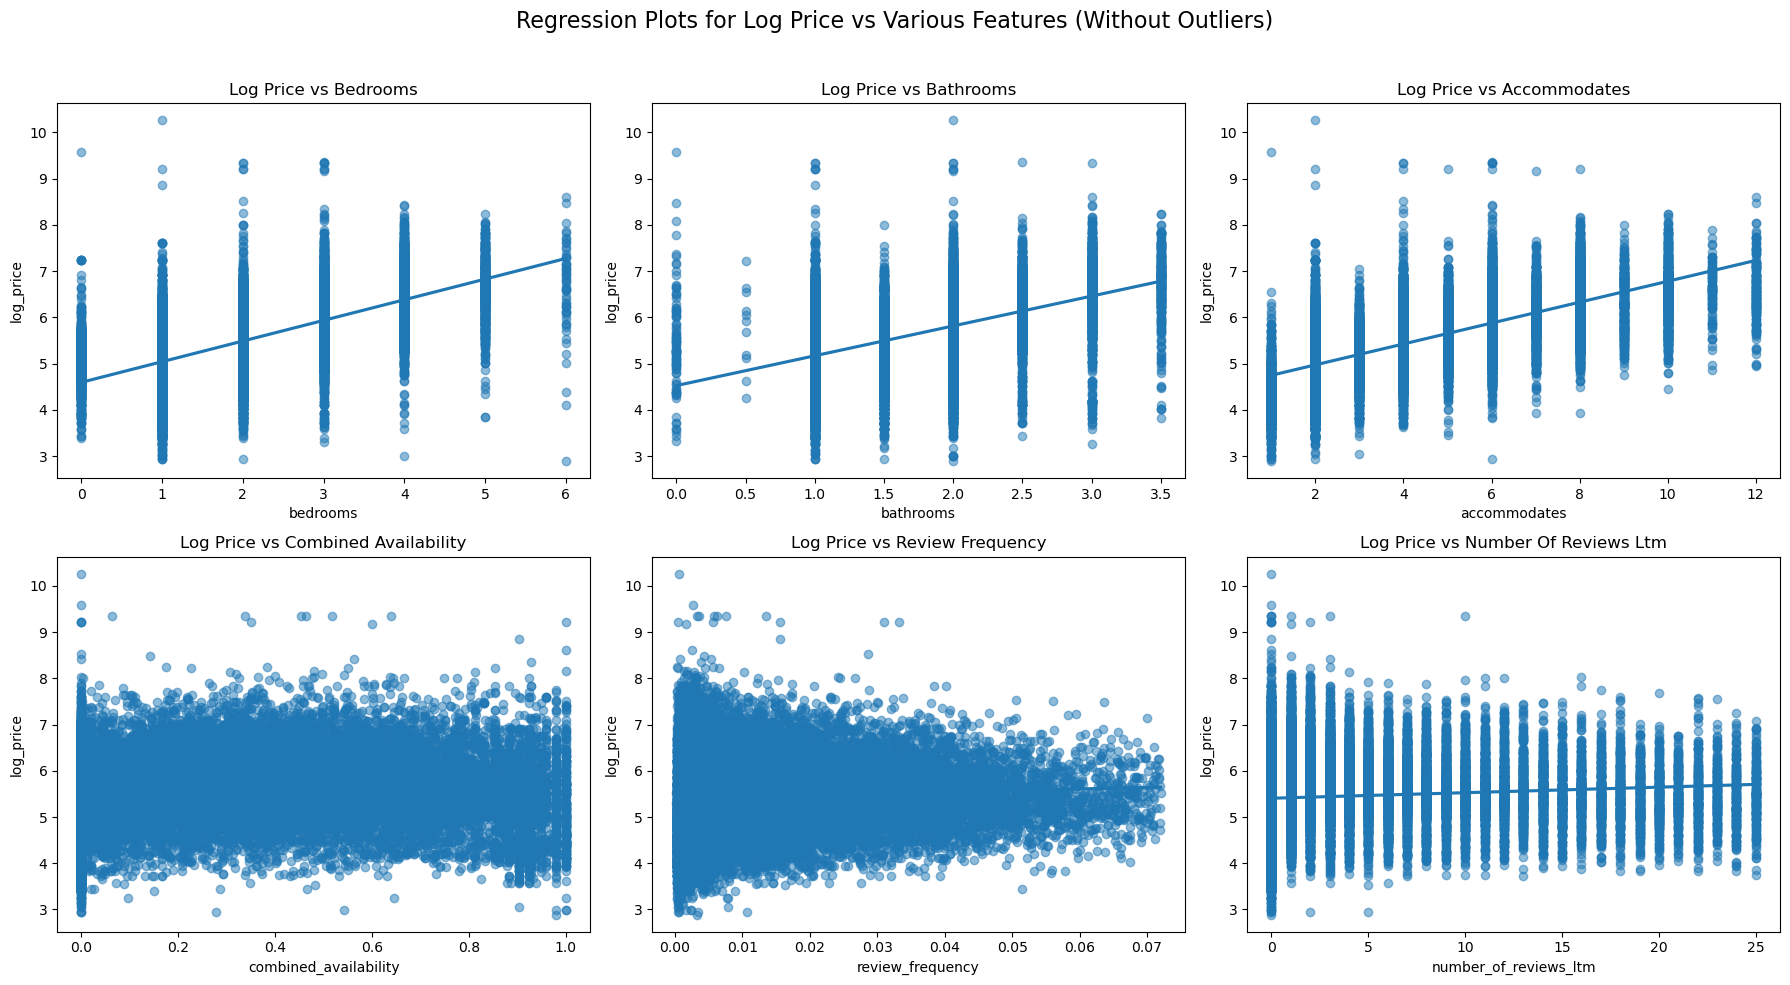

Number of rows after removing outliers: 24034


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
# Assuming 'data' is already loaded from the previous steps

# Define the outlier removal function
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Update features list with available columns
features = ['bedrooms', 'bathrooms', 'accommodates', 'combined_availability', 'review_frequency', 'number_of_reviews_ltm']

# Remove outliers from the updated features list
filtered_data = data.copy()

# Convert features to numeric, handling errors by coercing non-numeric values to NaN
for feature in features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')
    filtered_data = remove_outliers(filtered_data, feature)

# Drop any NaN values
filtered_data = filtered_data.dropna(subset=features + ['log_price'])

# Set up the plotting area and create regression plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Regression Plots for Log Price vs Various Features (Without Outliers)', fontsize=16)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Create regression plots
for i, feature in enumerate(features):
    sns.regplot(x=feature, y='log_price', data=filtered_data, scatter_kws={'alpha': 0.5}, ax=axes[i])
    axes[i].set_title(f'Log Price vs {feature.replace("_", " ").title()}', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Number of rows after removing outliers:", len(filtered_data))

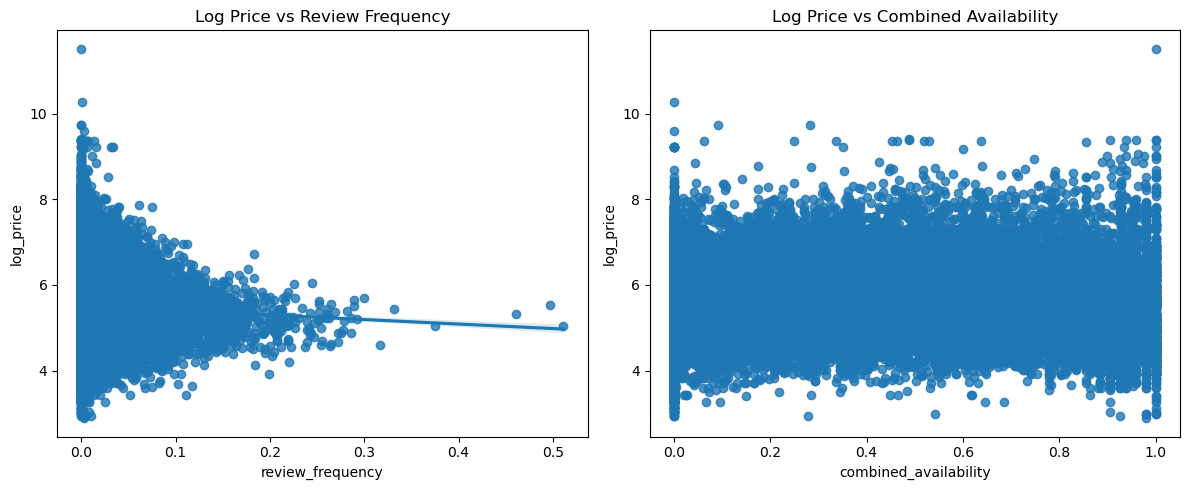

Number of rows in analysis: 37636


In [ ]:
# Step 1: Convert 'review_scores_rating' and 'availability_365' to numeric, handling errors
# Replace non-numeric values with NaN, then fill NaN with 0 for log transformation

data['review_scores_rating'] = pd.to_numeric(data['review_scores_rating'], errors='coerce').fillna(0)
data['availability_365'] = pd.to_numeric(data['availability_365'], errors='coerce').fillna(0)

# Convert 'review_frequency' and 'combined_availability' to numeric, handling errors
data['review_frequency'] = pd.to_numeric(data['review_frequency'], errors='coerce').fillna(0)
data['combined_availability'] = pd.to_numeric(data['combined_availability'], errors='coerce').fillna(0)

# Plot with transformed features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(x='review_frequency', y='log_price', data=data)
plt.title('Log Price vs Review Frequency')

plt.subplot(1, 2, 2)
sns.regplot(x='combined_availability', y='log_price', data=data)
plt.title('Log Price vs Combined Availability')

plt.tight_layout()
plt.show()

print("Number of rows in analysis:", len(data))

## Boxplot of Price (based on property type & room type)
# New dataframe: data_cleaned

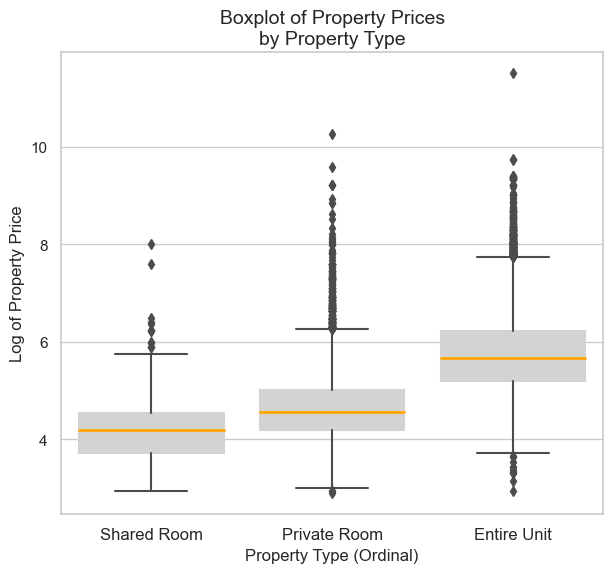

In [ ]:
sns.set(style="whitegrid")

#color_palette = sns.color_palette("pastel")
plt.figure(figsize=(7, 6))

# Plotting the boxplot with custom colors and linewidth for median
sns.boxplot(x='property_type_ordinal', y='log_price', boxprops=dict(color='lightgray'), data=data,
            medianprops={'color': 'orange', 'linewidth': 2})

# Setting plot labels and title
plt.xlabel('Property Type (Ordinal)', fontsize=12)
plt.ylabel('Log of Property Price', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Shared Room', 'Private Room', 'Entire Unit'],fontsize=12)
plt.title('Boxplot of Property Prices\nby Property Type', fontsize=14)

# Show the plot
plt.savefig('boxplot_with_outliers.png')

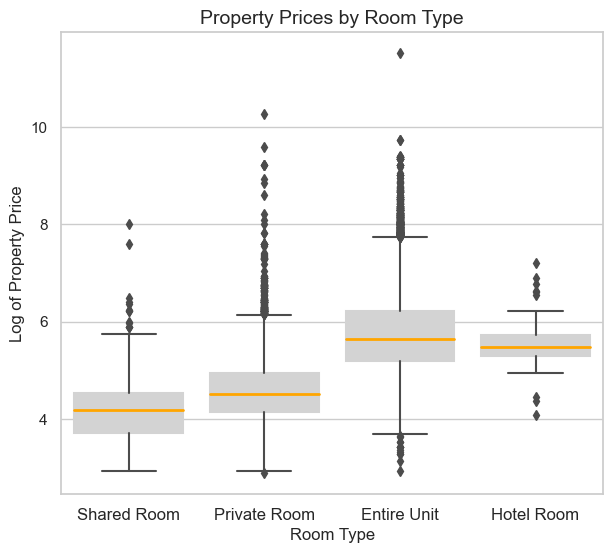

In [ ]:
sns.set(style="whitegrid")

#color_palette = sns.color_palette("pastel")
plt.figure(figsize=(7, 6))

# Plotting the boxplot with custom colors and linewidth for median
sns.boxplot(x='room_type_ordinal', y='log_price', boxprops=dict(color='lightgray'), data=data,
            medianprops={'color': 'orange', 'linewidth': 2})

# Setting plot labels and title
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Log of Property Price', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Shared Room', 'Private Room', 'Entire Unit','Hotel Room'],fontsize=12)
plt.title('Property Prices by Room Type', fontsize=14)
#plt.ylim(bottom=2, top=12)

# Show the plot
plt.savefig('boxplot_with_outliers_room.png')

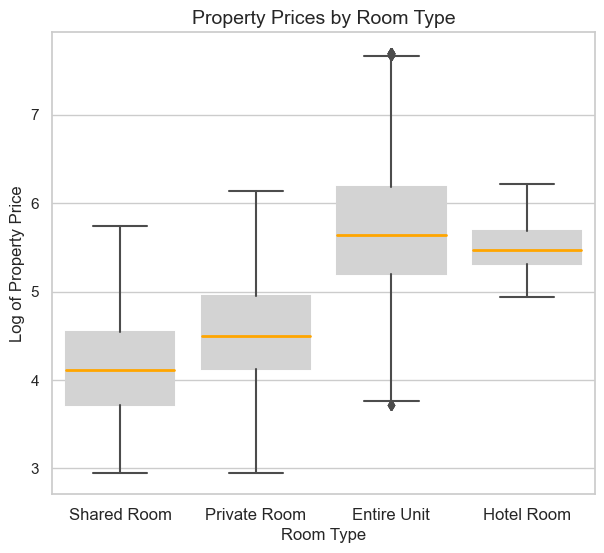

In [ ]:
# Plotting the boxplot without outliers
plt.figure(figsize=(7, 6))
sns.set(style="whitegrid")

# Plotting the boxplot with light gray box and orange median line
sns.boxplot(x='room_type_ordinal', y='log_price', boxprops=dict(color='lightgray'), data=data_cleaned,
            medianprops={'color': 'orange', 'linewidth': 2})

# Setting plot labels and title
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Log of Property Price', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Shared Room', 'Private Room', 'Entire Unit','Hotel Room'],fontsize=12)
plt.title('Property Prices by Room Type', fontsize=14)
#plt.ylim(bottom=2, top=8)

# Show the plot
plt.savefig('boxplot_without_outliers.png')

## Histogram

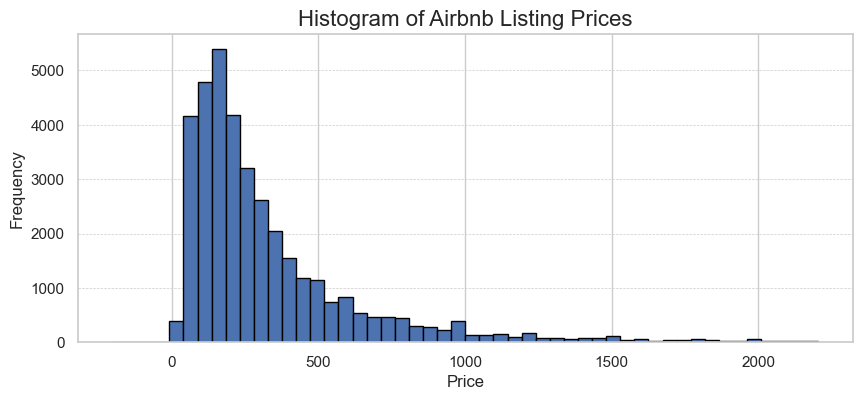

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(data_cleaned['price'], bins=50,edgecolor='black')
plt.title('Histogram of Airbnb Listing Prices', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.gca().set_axisbelow(True)
plt.savefig('histogramlisting.png')

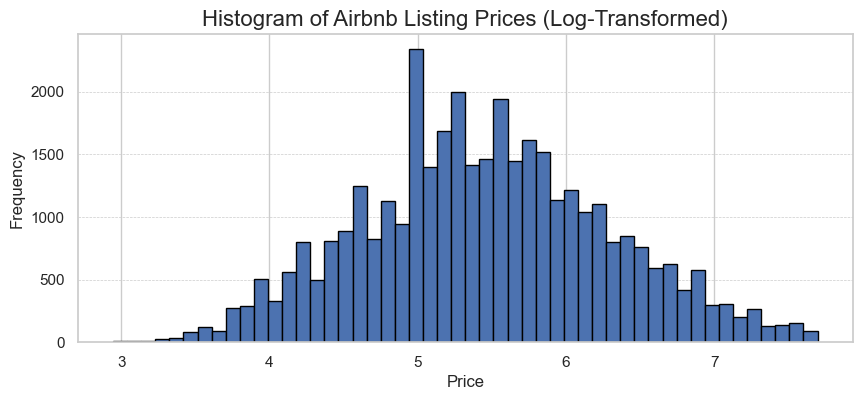

In [ ]:
#log transformed histogram
plt.figure(figsize=(10, 4))
plt.hist(data_cleaned['log_price'], bins=50,edgecolor='black')
plt.title('Histogram of Airbnb Listing Prices (Log-Transformed)', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.gca().set_axisbelow(True)
plt.savefig('loghistogramlisting.png')

# Variable Selection

In [ ]:
data.columns

Index(['name', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'listing_age (in days)',
       'days_since_last_review', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'property_type', 'property_type_ordinal', 'room_type',
       'room_type_ordinal', 'accommodates', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_

In [ ]:
features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
    'review_scores_rating', 'distance_to_city_center (in km)', 'property_type_ordinal',
    'room_type_ordinal', 'instant_bookable', 'host_is_superhost', 'is_high_rated',
    'combined_availability', 'is_peak_season (summer)', 'bedrooms_bathrooms',
    'bedrooms_accommodates', 'bathrooms_accommodates', 'listing_age (in days)',
    'days_since_last_review', 'review_frequency'
]

In [ ]:
X = data[features].fillna(0)
X.dtypes

latitude                           float64
longitude                          float64
accommodates                         int64
bedrooms                             int64
beds                                 int64
bathrooms                          float64
minimum_nights                       int64
maximum_nights                       int64
number_of_reviews                    int64
number_of_reviews_ltm                int64
review_scores_rating               Float64
distance_to_city_center (in km)    float64
property_type_ordinal                int64
room_type_ordinal                    int64
instant_bookable                    object
host_is_superhost                    int64
is_high_rated                        int64
combined_availability              float64
is_peak_season (summer)              int64
bedrooms_bathrooms                 float64
bedrooms_accommodates                int64
bathrooms_accommodates             float64
listing_age (in days)              float64
days_since_

In [ ]:
#change review_frequency into float64
data['review_frequency'] = data['review_frequency'].astype('float64')

## Modeling

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

## Hyperparameter Search

In [ ]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np
from optuna.samplers import TPESampler

## Random Forest

Random Forest Model Performance Metrics:
Training Set:
Mean Squared Error: 0.0786
R-squared: 0.8998
Adjusted R-squared: 0.8998
Validation Set:
Mean Squared Error: 0.2055
R-squared: 0.7431
Adjusted R-squared: 0.7422
Test Set:
Mean Squared Error: 0.1899
R-squared: 0.7505
Adjusted R-squared: 0.7498


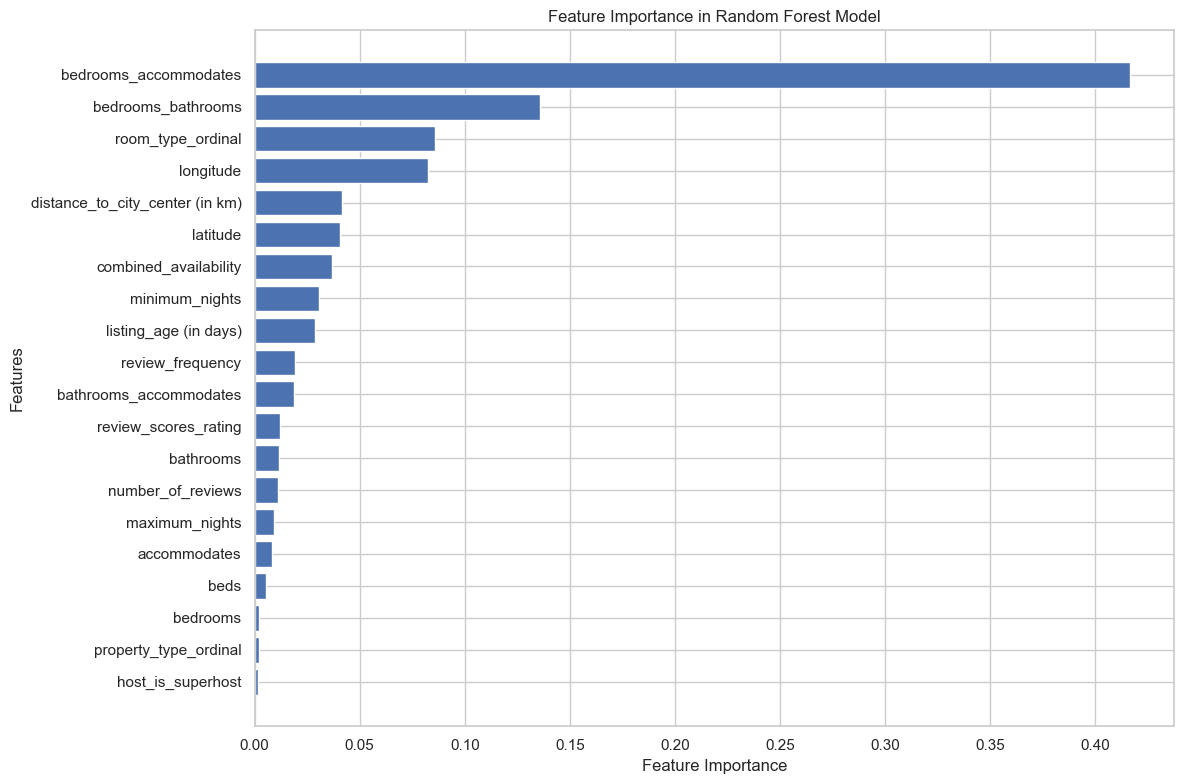

Top 10 Most Important Features:
                            feature  importance
16            bedrooms_accommodates    0.416543
15               bedrooms_bathrooms    0.135581
12                room_type_ordinal    0.085673
1                         longitude    0.082588
10  distance_to_city_center (in km)    0.041581
0                          latitude    0.040665
14            combined_availability    0.036715
6                    minimum_nights    0.030774
18            listing_age (in days)    0.028951
19                 review_frequency    0.019044


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
data = pd.read_excel('listings (3).xlsx')

# Select features
features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating',
    'distance_to_city_center (in km)', 'property_type_ordinal', 'room_type_ordinal',
    'host_is_superhost', 'combined_availability', 'bedrooms_bathrooms',
    'bedrooms_accommodates', 'bathrooms_accommodates', 'listing_age (in days)',
    'review_frequency'
]

# Prepare X and y
X = data[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = data['log_price']

# Split the dataset
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Make predictions
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)
test_pred = rf.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, X):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return mse, r2, adjusted_r2

train_metrics = calculate_metrics(y_train, train_pred, X_train)
val_metrics = calculate_metrics(y_val, val_pred, X_val)
test_metrics = calculate_metrics(y_test, test_pred, X_test)

print("Random Forest Model Performance Metrics:")
for name, metrics in zip(['Training', 'Validation', 'Test'],
                        [train_metrics, val_metrics, test_metrics]):
    print(f"\
{name} Set:")
    print(f"Mean Squared Error: {metrics[0]:.4f}")
    print(f"R-squared: {metrics[1]:.4f}")
    print(f"Adjusted R-squared: {metrics[2]:.4f}")

# Create feature importance visualization
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\
Top 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

## Trees & Forests

Model Performance Metrics:
Training Set:
Mean Squared Error: 0.1874
R-squared: 0.7612
Adjusted R-squared: 0.7610
Validation Set:
Mean Squared Error: 0.2579
R-squared: 0.6776
Adjusted R-squared: 0.6765
Test Set:
Mean Squared Error: 0.2524
R-squared: 0.6683
Adjusted R-squared: 0.6674


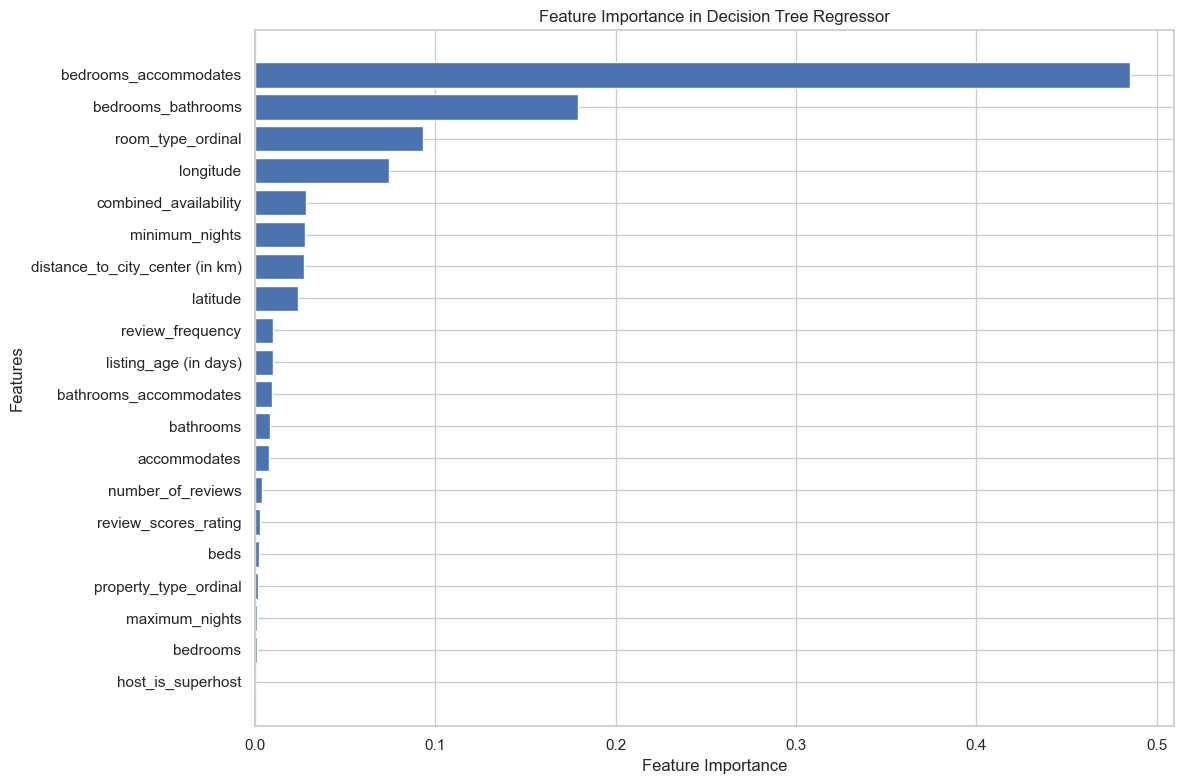

Top 10 Most Important Features:
                            feature  importance
16            bedrooms_accommodates    0.485198
15               bedrooms_bathrooms    0.179061
12                room_type_ordinal    0.093189
1                         longitude    0.074328
14            combined_availability    0.028551
6                    minimum_nights    0.027725
10  distance_to_city_center (in km)    0.027490
0                          latitude    0.023871
19                 review_frequency    0.010268
18            listing_age (in days)    0.010022


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and fit the model with best parameters
best_params = {'max_depth': 10, 'min_samples_split': 13}
dt = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                          min_samples_split=best_params['min_samples_split'],
                          random_state=42)
dt.fit(X_train, y_train)

# Make predictions on all sets
train_pred = dt.predict(X_train)
val_pred = dt.predict(X_val)
test_pred = dt.predict(X_test)

# Calculate metrics for all sets
def calculate_metrics(y_true, y_pred, X):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return mse, r2, adjusted_r2

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train, train_pred, X_train)
val_metrics = calculate_metrics(y_val, val_pred, X_val)
test_metrics = calculate_metrics(y_test, test_pred, X_test)

print("Model Performance Metrics:")
for name, metrics in zip(['Training', 'Validation', 'Test'],
                        [train_metrics, val_metrics, test_metrics]):
    print(f"\
{name} Set:")
    print(f"Mean Squared Error: {metrics[0]:.4f}")
    print(f"R-squared: {metrics[1]:.4f}")
    print(f"Adjusted R-squared: {metrics[2]:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree Regressor')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\
Top 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

# SHAP Values

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best_model)  # Use the best RandomForest model you trained
shap_values = explainer.shap_values(X_test)  # Calculate SHAP values on the test set

# Visualizing the SHAP values
shap.summary_plot(shap_values, X_test)
plt.savefig('shap_summary.png')

# NLP (Natural Language Processing)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
#do not tokenize empty columns
# Iterate through each review in the 'neighborhood_overview' column
for idx, overview in data['neighborhood_overview'].astype(str).items():
    # Check if the review is empty or consists of only spaces
    if not overview or overview.strip() == '':
        continue

    # Process each individual review using Spacy
    doc = nlp(overview)
    tokenized = [token.lower_ for token in doc]

In [ ]:
#convert to lower case
#filter out stop words and punctuation
tokenized = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct)]

In [ ]:
>>> complete_doc = nlp(complete_text)

>>> words = [
...     token.text
...     for token in complete_doc
...     if not token.is_stop and not token.is_punct
... ]

>>> print(Counter(words).most_common(5))

In [ ]:
# Only keeping the columns that we'll use
nlpdata=data[['host_id','neighborhood_overview', 'price']]

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(nlpdata.index), train_size=0.7,
                                            random_state=1)

# Write training and test sets
train = nlpdata.loc[index_train,:].copy()
test =  nlpdata.loc[index_test,:].copy()

y_train = train['price'].to_numpy()
y_test = test['price'].to_numpy()

In [ ]:
nlpdata

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, tokenizer = tokenized, min_df = 5, binary=True)
X_train = vectorizer.fit_transform(train['neighborhood_overview'])
X_test = vectorizer.transform(test['neighborhood_overview'])

feature_names = vectorizer.get_feature_names_out()

# NLP Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty = None) #dont do regularisation as a benchmark
logit.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
logit_l1= LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

In [ ]:
coefficient plot

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#TF-IDF Logistic Regression
median_price = data['log_price'].median()
data['price_category'] = (data['log_price'] > median_price).astype(int)  # 1 for high price, 0 for low price

# Step 2: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Adjust max_features as needed
X_text = vectorizer.fit_transform(data['neighborhood_overview'].astype(str))

# Step 3: Get the target variable 'price_category'
y = data['price_category']

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Step 5: Fit a Logistic Regression model
TFIDFmodel = LogisticRegression(max_iter=1000)
TFIDFmodel.fit(X_train, y_train)

# Step 6: Get the feature importance (coefficients) from the model
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = TFIDFmodel.coef_[0]

# Step 7: Sort the coefficients by importance
top_positive_coefficients = np.argsort(coefficients)[-15:]
top_negative_coefficients = np.argsort(coefficients)[:15]

# Step 8: Print the top words
print("Top words possitively associated with high prices:")
print(feature_names[top_positive_coefficients])

print("\nTop words negatively associated with high prices:")
print(feature_names[top_negative_coefficients])

Top words possitively associated with high prices:
['beach' 'events' 'salt' 'luxury' 'retail' 'woollahra' 'beachside'
 'destination' 'surf' 'experience' 'pittwater' 'family' 'kids' 'icebergs'
 'byron']

Top words negatively associated with high prices:
['studio' 'nice' 'newtown' 'bus' 'vietnamese' 'parramatta' 'bank'
 'strathfield' 'cinema' 'coles' 'ryde' 'gym' 'chatswood' 'cinemas'
 'picnics']


In [ ]:
data['neighborhood_overview'] = data['neighborhood_overview'].replace('Not Provided', '0')

In [ ]:
# Import necessary libraries
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
import numpy as np

# Step 1: Preprocess numerical features
numerical_features = ['listing_age (in days)', 'room_type_ordinal', 'bedrooms', 'bathrooms', 'accommodates',
                     'bedrooms_bathrooms', 'bedrooms_accommodates', 'bathrooms_accommodates',
                     'number_of_reviews_ltm', 'distance_to_city_center (in km)', 'combined_availability']

# Convert review_frequency to numeric
data['review_frequency'] = pd.to_numeric(data['review_frequency'], errors='coerce')

# Step 2: Handle numerical features
imputer = SimpleImputer(strategy='mean')
X_numeric = imputer.fit_transform(data[numerical_features])
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Step 3: Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(data['neighborhood_overview'].astype(str))

# Step 4: Combine features
X_combined = hstack([X_text, X_numeric_scaled])
y = data['log_price']

# Step 5: Train-Validation-Test split (60-20-20)
# First split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.4, random_state=42)
# Then split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 6: Train the model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Step 7: Make predictions
train_pred = gb_model.predict(X_train)
val_pred = gb_model.predict(X_val)
test_pred = gb_model.predict(X_test)

# Step 8: Calculate metrics for all sets
def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return mse, rmse, r2, adjusted_r2

n_features = X_combined.shape[1]

train_metrics = calculate_metrics(y_train, train_pred, n_features)
val_metrics = calculate_metrics(y_val, val_pred, n_features)
test_metrics = calculate_metrics(y_test, test_pred, n_features)

print("Training Set Metrics:")
print(f"MSE: {train_metrics[0]:.4f}")
print(f"RMSE: {train_metrics[1]:.4f}")
print(f"R2: {train_metrics[2]:.4f}")
print(f"Adjusted R2: {train_metrics[3]:.4f}\
")

print("Validation Set Metrics:")
print(f"MSE: {val_metrics[0]:.4f}")
print(f"RMSE: {val_metrics[1]:.4f}")
print(f"R2: {val_metrics[2]:.4f}")
print(f"Adjusted R2: {val_metrics[3]:.4f}\
")

print("Test Set Metrics:")
print(f"MSE: {test_metrics[0]:.4f}")
print(f"RMSE: {test_metrics[1]:.4f}")
print(f"R2: {test_metrics[2]:.4f}")
print(f"Adjusted R2: {test_metrics[3]:.4f}")

Training Set Metrics:
MSE: 0.2378
RMSE: 0.4876
R2: 0.6972
Adjusted R2: 0.6830
Validation Set Metrics:
MSE: 0.2450
RMSE: 0.4950
R2: 0.6877
Adjusted R2: 0.6393
Test Set Metrics:
MSE: 0.2326
RMSE: 0.4823
R2: 0.6989
Adjusted R2: 0.6522


Mean Squared Error: 0.22382087707016124
R-squared: 0.7059266286337007
Adjusted R-squared: 0.6602470811551597


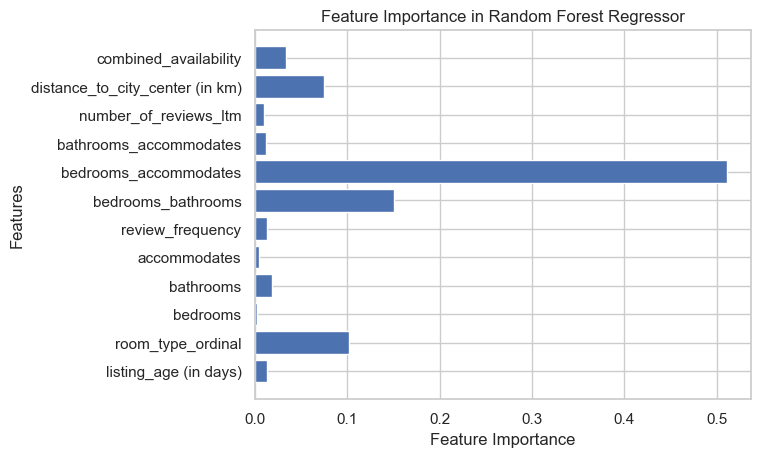

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

# Assuming 'neighborhood_overview' contains the text to be vectorized
# Step 1: Vectorize the 'neighborhood_overview' text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(data['neighborhood_overview'].astype(str))

# Step 2: Extract your existing numerical features
numerical_features = ['listing_age (in days)','room_type_ordinal','bedrooms', 'bathrooms', 'accommodates',
             'review_frequency', 'bedrooms_bathrooms', 'bedrooms_accommodates', 'bathrooms_accommodates', 'number_of_reviews_ltm','distance_to_city_center (in km)','combined_availability']

# Fill missing values in the numerical features
X_numeric = data[numerical_features].fillna(0)

# Step 3: Standardize the numerical features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Step 4: Combine the TF-IDF matrix with the standardized numerical features
X_combined = hstack([X_text, X_numeric_scaled])

# Step 5: Get the target variable 'log_price'
y = data['log_price']

# Step 6: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 7: Define best hyperparameters for Random Forest (assuming you used RandomizedSearchCV to get these)
best_params = {'max_depth': 10, 'min_samples_split': 13}

# Step 8: Initialize and fit the Random Forest Regressor
model = RandomForestRegressor(max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Optional: Visualize feature importance from the Random Forest
import matplotlib.pyplot as plt

# Get feature importance (this only applies to the numerical features, not the TF-IDF ones)
feature_importance = model.feature_importances_[-len(numerical_features):]  # Only numerical features have importance
plt.barh(numerical_features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

# Lasso Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Reload the Excel file into a dataframe using openpyxl
listings_df = pd.read_excel('listings (3).xlsx', engine='openpyxl')

# Fill missing values with median for numeric columns and mode for categorical columns
def fill_missing_values(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column] = df[column].fillna(df[column].median())
        else:
            df[column] = df[column].fillna(df[column].mode()[0])
    return df

listings_df = fill_missing_values(listings_df)

# Convert non-numeric features to numeric using Label Encoding
label_encoders = {}
for column in listings_df.select_dtypes(include=['object']).columns:
    listings_df[column] = listings_df[column].astype(str)  # Ensure all are strings
    le = LabelEncoder()
    listings_df[column] = le.fit_transform(listings_df[column])
    label_encoders[column] = le

# Prepare feature set and target variable
features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
    'review_scores_rating', 'distance_to_city_center (in km)', 'property_type_ordinal',
    'room_type_ordinal', 'instant_bookable', 'host_is_superhost', 'is_high_rated',
    'combined_availability', 'is_peak_season (summer)', 'bedrooms_bathrooms',
    'bedrooms_accommodates', 'bathrooms_accommodates', 'listing_age (in days)',
    'days_since_last_review', 'review_frequency'
]

X = listings_df[features]
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
y = np.log1p(listings_df['price'])

# First split: training+validation (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training (80% of 80%) and validation (20% of 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("Dataset shapes:")
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Dataset shapes:
Training set: (24086, 25)
Validation set: (6022, 25)
Test set: (7528, 25)


C:\Users\ALIENWARE\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Verify numeric columns
print("Checking for non-numeric columns:")
print(X.dtypes)

Checking for non-numeric columns:
latitude                           float64
longitude                          float64
accommodates                         int64
bedrooms                             int64
beds                                 int64
bathrooms                          float64
minimum_nights                       int64
maximum_nights                       int64
number_of_reviews                    int64
number_of_reviews_ltm                int64
review_scores_rating                 int32
distance_to_city_center (in km)    float64
property_type_ordinal                int64
room_type_ordinal                    int64
instant_bookable                     int32
host_is_superhost                    int64
is_high_rated                        int64
combined_availability              float64
is_peak_season (summer)              int64
bedrooms_bathrooms                 float64
bedrooms_accommodates                int64
bathrooms_accommodates             float64
listing_age (in days

In [ ]:
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
y = np.log1p(listings_df['price'])

# Fill NaN values in the target variable y with 0
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
y = np.log1p(listings_df['price'].fillna(0))

# Fill NaN values with 0
X_clean = X.fillna(0)
y_clean = y.fillna(0)


# Now split the cleaned data
X_temp, X_test, y_temp, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Lasso model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred_val = lasso.predict(X_val_scaled)
y_pred_test = lasso.predict(X_test_scaled)

# Calculate metrics
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Calculate adjusted R2
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

n_val = len(y_val)
n_test = len(y_test)
p = X_val.shape[1]
adj_r2_val = adjusted_r2(r2_val, n_val, p)
adj_r2_test = adjusted_r2(r2_test, n_test, p)

print("Validation Set Results:")
print("Mean Squared Error: " + str(mse_val))
print("R2 Score: " + str(r2_val))
print("Adjusted R2 Score: " + str(adj_r2_val))

print("\
Test Set Results:")
print("Mean Squared Error: " + str(mse_test))
print("R2 Score: " + str(r2_test))
print("Adjusted R2 Score: " + str(adj_r2_test))

# Display feature importances
feature_importance = pd.DataFrame({'feature': features, 'importance': np.abs(lasso.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\
Top 10 most important features:")
print(feature_importance.head(10))

Validation Set Results:
Mean Squared Error: 0.3677246293598673
R2 Score: 0.5430102488881645
Adjusted R2 Score: 0.5411048546623813
Test Set Results:
Mean Squared Error: 0.3189407869698011
R2 Score: 0.5809506772027628
Adjusted R2 Score: 0.5795542185157553
Top 10 most important features:
                   feature  importance
13       room_type_ordinal    0.196586
2             accommodates    0.186379
3                 bedrooms    0.138688
5                bathrooms    0.132319
0                 latitude    0.028978
17   combined_availability    0.018616
6           minimum_nights    0.012576
12   property_type_ordinal    0.011724
23  days_since_last_review    0.010862
1                longitude    0.001014


C:\Users\ALIENWARE\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create ElasticNet model
elastic_net = ElasticNet(random_state=42, max_iter=10000)

# Perform grid search
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Calculate metrics for training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
n_train = len(y_train)
p = X_train.shape[1]
adj_r2_train = adjusted_r2(r2_train, n_train, p)


# Make predictions and evaluate on validation set
y_pred_val = best_model.predict(X_val_scaled)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
adjusted_r2_val = 1 - (1 - r2_val) * (len(y_val) - 1) / (len(y_val) - X_val.shape[1] - 1)

# Make predictions and evaluate on test set
y_pred_test = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
adjusted_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("Training Set Results:")
print("Mean Squared Error: " + str(mse_train))
print("R2 Score: " + str(r2_train))
print("Adjusted R2 Score: " + str(adj_r2_train))

print("Best parameters:", grid_search.best_params_)
print("\
Validation Set Results:")
print("Mean Squared Error: " + str(mse_val))
print("R2 Score: " + str(r2_val))
print("Adjusted R2 Score: " + str(adjusted_r2_val))

print("\
Test Set Results:")
print("Mean Squared Error: " + str(mse_test))
print("R2 Score: " + str(r2_test))
print("Adjusted R2 Score: " + str(adjusted_r2_test))

# Display feature importances
feature_importance = pd.DataFrame({'feature': features, 'importance': np.abs(best_model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\
Top 10 most important features:")
print(feature_importance.head(10))

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.9}
Validation Set Results:
Mean Squared Error: 0.2973602306199939
R2 Score: 0.6304555992941064
Adjusted R2 Score: 0.6289148037608097
Test Set Results:
Mean Squared Error: 0.26456229113906954
R2 Score: 0.6523973932816256
Adjusted R2 Score: 0.6512390268236199
Top 10 most important features:
                            feature  importance
11  distance_to_city_center (in km)    1.536172
0                          latitude    1.530886
2                      accommodates    0.268998
3                          bedrooms    0.221208
13                room_type_ordinal    0.187756
5                         bathrooms    0.181811
20            bedrooms_accommodates    0.164732
17            combined_availability    0.087629
1                         longitude    0.084245
23           days_since_last_review    0.078243


## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Perform grid search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Using unscaled features for tree-based models

# Get best model
best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

# Make predictions and evaluate on validation set
y_pred_val = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
adjusted_r2_val = 1 - (1 - r2_val) * (len(y_val) - 1) / (len(y_val) - X_val.shape[1] - 1)

print("\
Validation Set Results:")
print("Mean Squared Error: " + str(mse_val))
print("R2 Score: " + str(r2_val))
print("Adjusted R2 Score: " + str(adjusted_r2_val))

# Make predictions and evaluate on test set
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
adjusted_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("\
Test Set Results:")
print("Mean Squared Error: " + str(mse_test))
print("R2 Score: " + str(r2_test))
print("Adjusted R2 Score: " + str(adjusted_r2_test))

# Extract and display feature importances
feature_importance = pd.DataFrame({'feature': features, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\
Top 10 most important features:")
print(feature_importance.head(10))

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Validation Set Results:
Mean Squared Error: 0.19752346309002036
R2 Score: 0.7545277334471965
Adjusted R2 Score: 0.7535042500142712
Test Set Results:
Mean Squared Error: 0.17407320029923815
R2 Score: 0.7712890301814852
Adjusted R2 Score: 0.7705268635265314
Top 10 most important features:
                            feature  importance
20            bedrooms_accommodates    0.341778
21           bathrooms_accommodates    0.120057
19               bedrooms_bathrooms    0.113456
13                room_type_ordinal    0.107715
1                         longitude    0.079221
0                          latitude    0.035412
11  distance_to_city_center (in km)    0.035334
17            combined_availability    0.028636
6                    minimum_nights    0.028022
2                      accommodates    0.023933


## Model Stacking

In [ ]:
# Calculate weights based on R2 scores
r2_lasso = 0.5795542185157553  # adj R2 score from Lasso
r2_elastic_net = 0.6512390268236199  # adj R2 score from Elastic Net
r2_gradient_boosting = 0.7705194588315127  # adj R2 score from Gradient Boosting

# Sum of R2 scores
r2_sum = r2_lasso + r2_elastic_net + r2_gradient_boosting

# Calculate weights
weight_lasso = r2_lasso / r2_sum
weight_elastic_net = r2_elastic_net / r2_sum
weight_gradient_boosting = r2_gradient_boosting / r2_sum

print("Model Weights:")
print("Lasso Weight: " + str(weight_lasso))
print("Elastic Net Weight: " + str(weight_elastic_net))
print("Gradient Boosting Weight: " + str(weight_gradient_boosting))

# Fit the Gradient Boosting model with the best parameters
best_gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
best_gb_model.fit(X_train, y_train)

Model Weights:
Lasso Weight: 0.28958703820143655
Elastic Net Weight: 0.3254059325493653
Gradient Boosting Weight: 0.385007029249198


GradientBoostingRegressor(max_depth=5, n_estimators=300, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

# Create stacked datasets using predictions from all three models
X_train_stack = np.column_stack((
    lasso.predict(X_train_scaled),
    best_model.predict(X_train_scaled),
    best_gb_model.predict(X_train)
))

X_val_stack = np.column_stack((
    lasso.predict(X_val_scaled),
    best_model.predict(X_val_scaled),
    best_gb_model.predict(X_val)
))

X_test_stack = np.column_stack((
    lasso.predict(X_test_scaled),
    best_model.predict(X_test_scaled),
    best_gb_model.predict(X_test)
))

# Fit meta-model
meta_model = LinearRegression()
meta_model.fit(X_train_stack, y_train)

# Evaluate stacked model on validation set
y_pred_val_stack = meta_model.predict(X_val_stack)
mse_val_stack = mean_squared_error(y_val, y_pred_val_stack)
r2_val_stack = r2_score(y_val, y_pred_val_stack)
adj_r2_val_stack = 1 - (1 - r2_val_stack) * (len(y_val) - 1) / (len(y_val) - X_val_stack.shape[1] - 1)

print("Validation Set Results for Stacked Model:")
print("Mean Squared Error:", mse_val_stack)
print("R2 Score:", r2_val_stack)
print("Adjusted R2 Score:", adj_r2_val_stack)

# Evaluate stacked model on test set
y_pred_test_stack = meta_model.predict(X_test_stack)
mse_test_stack = mean_squared_error(y_test, y_pred_test_stack)
r2_test_stack = r2_score(y_test, y_pred_test_stack)
adj_r2_test_stack = 1 - (1 - r2_test_stack) * (len(y_test) - 1) / (len(y_test) - X_test_stack.shape[1] - 1)

print("\
Test Set Results for Stacked Model:")
print("Mean Squared Error:", mse_test_stack)
print("R2 Score:", r2_test_stack)
print("Adjusted R2 Score:", adj_r2_test_stack)

# Print meta-model coefficients (weights assigned to each model)
print("\
Meta-model coefficients (weights):")
print("Lasso:", meta_model.coef_[0])
print("Elastic Net:", meta_model.coef_[1])
print("Gradient Boosting:", meta_model.coef_[2])

C:\Users\ALIENWARE\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Validation Set Results for Stacked Model:
Mean Squared Error: 0.1997883070731022
R2 Score: 0.7517130987844669
Adjusted R2 Score: 0.7515893266502618
Test Set Results for Stacked Model:
Mean Squared Error: 0.17790136847785795
R2 Score: 0.7662592837572485
Adjusted R2 Score: 0.7661660857045202
Meta-model coefficients (weights):
Lasso: -0.2008214428633548
Elastic Net: -0.011128005045309839
Gradient Boosting: 1.1686952460561277


C:\Users\ALIENWARE\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\ALIENWARE\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Create a new GradientBoostingRegressor
gb_tuning = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_tuning,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

print("Best parameters found:")
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

# Ridge Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define features
features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
    'review_scores_rating', 'distance_to_city_center (in km)', 'property_type_ordinal',
    'room_type_ordinal', 'instant_bookable', 'host_is_superhost', 'is_high_rated',
    'combined_availability', 'is_peak_season (summer)', 'bedrooms_bathrooms',
    'bedrooms_accommodates', 'bathrooms_accommodates', 'listing_age (in days)',
    'days_since_last_review', 'review_frequency'
]

# Handle missing values
for feature in features:
    if listings_df[feature].isnull().sum() > 0:
        listings_df[feature].fillna(listings_df[feature].median(), inplace=True)

# Prepare features and target
X = listings_df[features]
y = listings_df['log_price']

# Now split the cleaned data
X_temp, X_test, y_temp, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)



print("Data prepared and split into training and testing sets.")
print("\
Feature matrix shape:", X.shape)

Data prepared and split into training and testing sets.
Feature matrix shape: (37636, 25)


In [ ]:
# Step 1: Fit Ridge regression model
ridge_model = Ridge(alpha=2.68)  # Using the previously found optimal alpha
ridge_model.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Step 3: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print("Ridge Regression Results:")
print("Mean Squared Error:", mse)
print("R2 Score:", r2)
print("Adjusted R2 Score:", adj_r2)

Ridge Regression Results:
Mean Squared Error: 0.261132328249273
R2 Score: 0.6569039464880833
Adjusted R2 Score: 0.6557605978693419


In [ ]:
# Step 4: Analyze feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge_model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\
Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
                    Feature  Coefficient  Abs_Coefficient
0                  latitude     1.390404         1.390404
13        room_type_ordinal     0.406845         0.406845
17    combined_availability     0.285714         0.285714
5                 bathrooms     0.205256         0.205256
3                  bedrooms     0.188867         0.188867
1                 longitude     0.187510         0.187510
12    property_type_ordinal     0.150896         0.150896
15        host_is_superhost     0.110216         0.110216
2              accommodates     0.109783         0.109783
18  is_peak_season (summer)     0.053228         0.053228


#KNN

In [ ]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Check for constant or highly correlated features
correlation_matrix = pd.DataFrame(X_train_scaled).corr()

# Identify features with high correlation
high_corr_pairs = np.where(correlation_matrix > 0.95)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

print("Highly correlated feature pairs:", high_corr_pairs)

# Remove one feature from each highly correlated pair
features_to_drop = [pair[1] for pair in high_corr_pairs]
X_train_filtered = np.delete(X_train_scaled, features_to_drop, axis=1)
X_test_filtered = np.delete(X_test_scaled, features_to_drop, axis=1)

# First handle NaN values in the dataset
X_train_clean = pd.DataFrame(X_train_scaled).fillna(0)
X_test_clean = pd.DataFrame(X_test_scaled).fillna(0)

# Calculate covariance matrix and add small constant
Sigma = np.cov(X_train_clean, rowvar=False)
epsilon = 1e-6
Sigma = Sigma + epsilon * np.eye(Sigma.shape[0])
VI = np.linalg.inv(Sigma)

# Function to evaluate model with adjusted R2
def evaluate_model_with_adj_r2(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate adjusted R2
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return rmse, mse, r2, adj_r2

# Initialize and evaluate KNN models
models = {
    'KNN (5 neighbors)': KNeighborsRegressor(n_neighbors=5),
    'KNN (15 neighbors)': KNeighborsRegressor(n_neighbors=15),
    'KNN (Mahalanobis)': KNeighborsRegressor(n_neighbors=15, metric='mahalanobis', metric_params={'VI': VI})
}

# Create results DataFrame
results = pd.DataFrame(columns=['Model', 'RMSE', 'MSE', 'R2', 'Adjusted R2'])

# Evaluate each model
for model_name, model in models.items():
    rmse, mse, r2, adj_r2 = evaluate_model_with_adj_r2(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )
    results.loc[len(results)] = [model_name, rmse, mse, r2, adj_r2]

# Print results
print("\
Model Performance Metrics:")
print(results.round(4))

Highly correlated feature pairs: [(0, 1), (0, 11), (1, 11), (19, 21)]
Model Performance Metrics:
                Model    RMSE     MSE      R2  Adjusted R2
0   KNN (5 neighbors)  0.5038  0.2538  0.6665       0.6654
1  KNN (15 neighbors)  0.4916  0.2417  0.6825       0.6814
2   KNN (Mahalanobis)  0.4888  0.2390  0.6860       0.6850


# **XG BOOST**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing: Select relevant features and handle missing values
# Important features based on previous analysis
features = ['accommodates', 'bedrooms', 'number_of_reviews', 'availability_365', 'review_scores_rating']
target = 'log_price'

# Drop rows with missing target values and fill any missing feature values
df = df.dropna(subset=[target])  # Drop rows where target is NaN
df[features] = df[features].fillna(0)  # Fill missing values in features with 0

# Convert 'review_scores_rating' to numeric, handling errors
df['review_scores_rating'] = pd.to_numeric(df['review_scores_rating'], errors='coerce')
# errors='coerce' will replace non-numeric values with NaN

# Fill any newly created NaNs with 0
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)


# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

# Train the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Assuming 'y_test' are true target values and 'y_pred' are model's predictions
r2 = r2_score(y_test, y_pred)
n = len(y_test)  # Number of observations
p = len(X_test.columns)  # Number of features/predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")


Mean Squared Error: 0.333990723648206
Root Mean Squared Error: 0.5779193054814885
R-squared: 0.5611768687801649
Adjusted R-squared: 0.5608851756591733


In [ ]:
#Hyperparamater tuning with Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, alpha=10),
                           param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


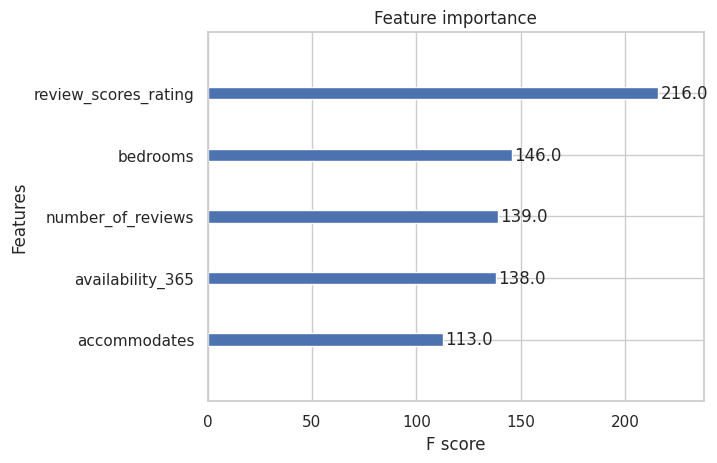

In [ ]:
#Feature Importance Analysis
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.show()

In [ ]:
#Cross-Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xg_reg, X, y, scoring='neg_mean_squared_error', cv=5)
print("Cross-validated MSE:", -scores.mean())

Cross-validated MSE: 0.3478504509358894


# Additional Features introduced

In [ ]:
features = [
    'accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews', 'availability_365', 'review_scores_rating',
    'review_scores_location', 'review_scores_cleanliness', 'distance_to_city_center (in km)',
    'property_type_ordinal', 'room_type_ordinal'
]
target = 'log_price'

# Drop rows with missing target values and fill any missing feature values
df = df.dropna(subset=[target])
df[features] = df[features].fillna(0)

# Replace 'Not Reviewed' with 0 before converting to numeric
for col in ['review_scores_rating', 'review_scores_location', 'review_scores_cleanliness']:
    df[col] = df[col].replace('Not Reviewed', 0)

# Convert columns to appropriate types and standardize values
df['review_scores_rating'] = pd.to_numeric(df['review_scores_rating'], errors='coerce').fillna(0)
df['log_price'] = df['log_price'].replace('[\$,]', '', regex=True).astype(float)  # remove $ symbol

# Define feature matrix X and target vector y
X = df[features]
y = df[target]

# Scaling and encoding the features
numerical_features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews', 'availability_365',
                      'review_scores_rating', 'review_scores_location', 'review_scores_cleanliness',
                      'distance_to_city_center (in km)']
categorical_features = ['property_type_ordinal', 'room_type_ordinal']

# Preprocess pipeline for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Build the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                               max_depth=5, alpha=10, n_estimators=100))
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of features after encoding
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Squared Error: 0.22859742240687494
Root Mean Squared Error: 0.478118627964729
R-squared: 0.6996508298385281
Adjusted R-squared: 0.6992112554809209


In [ ]:
# Hyperparameter tuning with Grid Search
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}


In [ ]:
# Cross-validation for model robustness
cv_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
print("Cross-validated MSE:", -cv_scores.mean())

Cross-validated MSE: 0.240101171588803


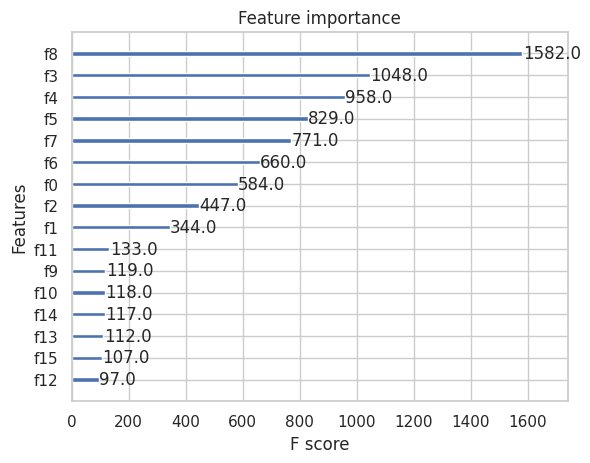

In [ ]:
# Feature Importance
xg_reg = grid_search.best_estimator_.named_steps['model']
xgb.plot_importance(xg_reg)
plt.show()

# Interaction terms

In [ ]:
# Create interaction terms
df['accommodates_x_bedrooms'] = df['accommodates'] * df['bedrooms']
df['bedrooms_x_bathrooms'] = df['bedrooms'] * df['bathrooms']
# Add more interaction terms if needed

# Update features list with interaction terms
features.extend(['accommodates_x_bedrooms', 'bedrooms_x_bathrooms'])

# Define feature matrix X and target vector y
X = df[features]
y = df[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for scaling and encoding
numerical_features = [f for f in features if f not in ['property_type_ordinal', 'room_type_ordinal']]
categorical_features = ['property_type_ordinal', 'room_type_ordinal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Handle unknown categories
    ])

# Build the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror',
                               colsample_bytree=0.3,
                               learning_rate=0.1,
                               max_depth=5,
                               alpha=10,
                               n_estimators=100))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of features after encoding
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Squared Error: 0.22769155280040362
Root Mean Squared Error: 0.4771703603540392
R-squared: 0.7008410321676423
Adjusted R-squared: 0.7003234560987281


In [ ]:
# Hyperparameter tuning with Grid Search
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}


In [ ]:
# Cross-validation for model robustness
cv_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
print("Cross-validated MSE:", -cv_scores.mean())

Cross-validated MSE: 0.23984882268746865


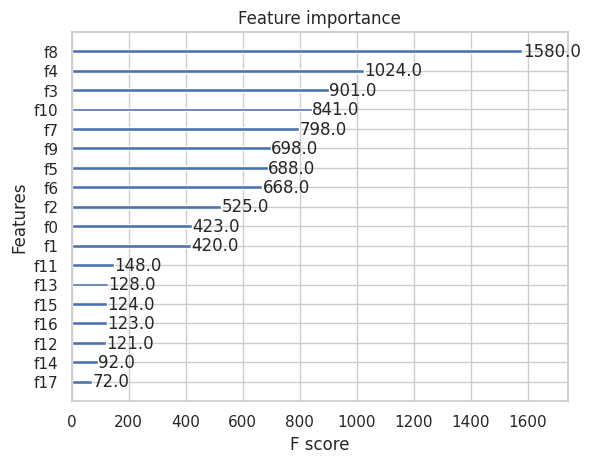

In [ ]:
# Feature Importance
xg_reg = grid_search.best_estimator_.named_steps['model']
xgb.plot_importance(xg_reg)
plt.show()